In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

# EDA

In [2]:
df = pd.read_csv('../2021_matches.csv')
df.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,118.0,748.0,-56.0,-4.0,2.0,0.0,1.0,0.0,1.0,1.0
1,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,84.0,2120.0,3405.0,62.0,3.0,2.0,0.0,2.0,0.0,3.0
2,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,143.0,1578.0,354.0,15.0,2.0,3.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,120.0,124.0,102.0,10.0,0.0,4.0,2.0,1.0,1.0,2.0
4,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,25.0,448.0,450.0,3.0,1.0,4.0,0.0,0.0,2.0,2.0


### Added death_adj field to prevent divide by zero issues for KDA calc

In [3]:
df['death_15_adj'] =  df.deathsat15.map(lambda x: 1 if x==0 else x)
df['kda_15'] = (df.killsat15 + df.assistsat15)/df.death_15_adj

### Converted 'side' field to a 1/0

In [4]:
df['side_bool'] = df.side.map(lambda x: 1 if x == 'Blue' else 0)

### Creating KDA by position fields

In [5]:
pos_lst = ['top','jng','mid','bot','sup']

df_teams = df[df.position == 'team'].reset_index()
df_teams['id_side'] = df_teams.gameid + '_' + df_teams.side
df_teams.set_index('id_side')

df_players = df[df.position != 'team']

Created pivoted table of kda by position grouped by the gameid+side; to be joined with the teams dataframe

In [6]:
df_players_piv = df_players[['position','kda_15']].pivot(values ='kda_15',columns = 'position')

df_players_piv['gameid'] = df_players.gameid
df_players_piv['side'] = df_players.side
df_players_piv['id_side'] = df_players_piv.gameid + '_' + df_players_piv.side

df_players_piv = df_players_piv.fillna(0)
df_players_piv.head(10)
df_players_piv = df_players_piv.groupby(['id_side']).sum().reset_index()
df_players_piv.set_index('id_side')

## renames position columns to include the timestamp
df_players_piv.columns = [col + '_15' for col in df_players_piv.columns.values]
df_players_piv.rename({'id_side_15':'id_side'}, axis = 1, inplace = True)

Joined the position pivot onto the teams dataframe on the gameid+side

In [7]:
df_agg = df_teams.set_index('id_side').join(df_players_piv.set_index('id_side'))

In [8]:
col_lst = ['kda_15','top_15','jng_15','mid_15','bot_15','sup_15','side_bool','result','csdiffat15','killsat15','assistsat15','deathsat15','golddiffat15','xpdiffat15']
df_plot = df_agg[col_lst].dropna()

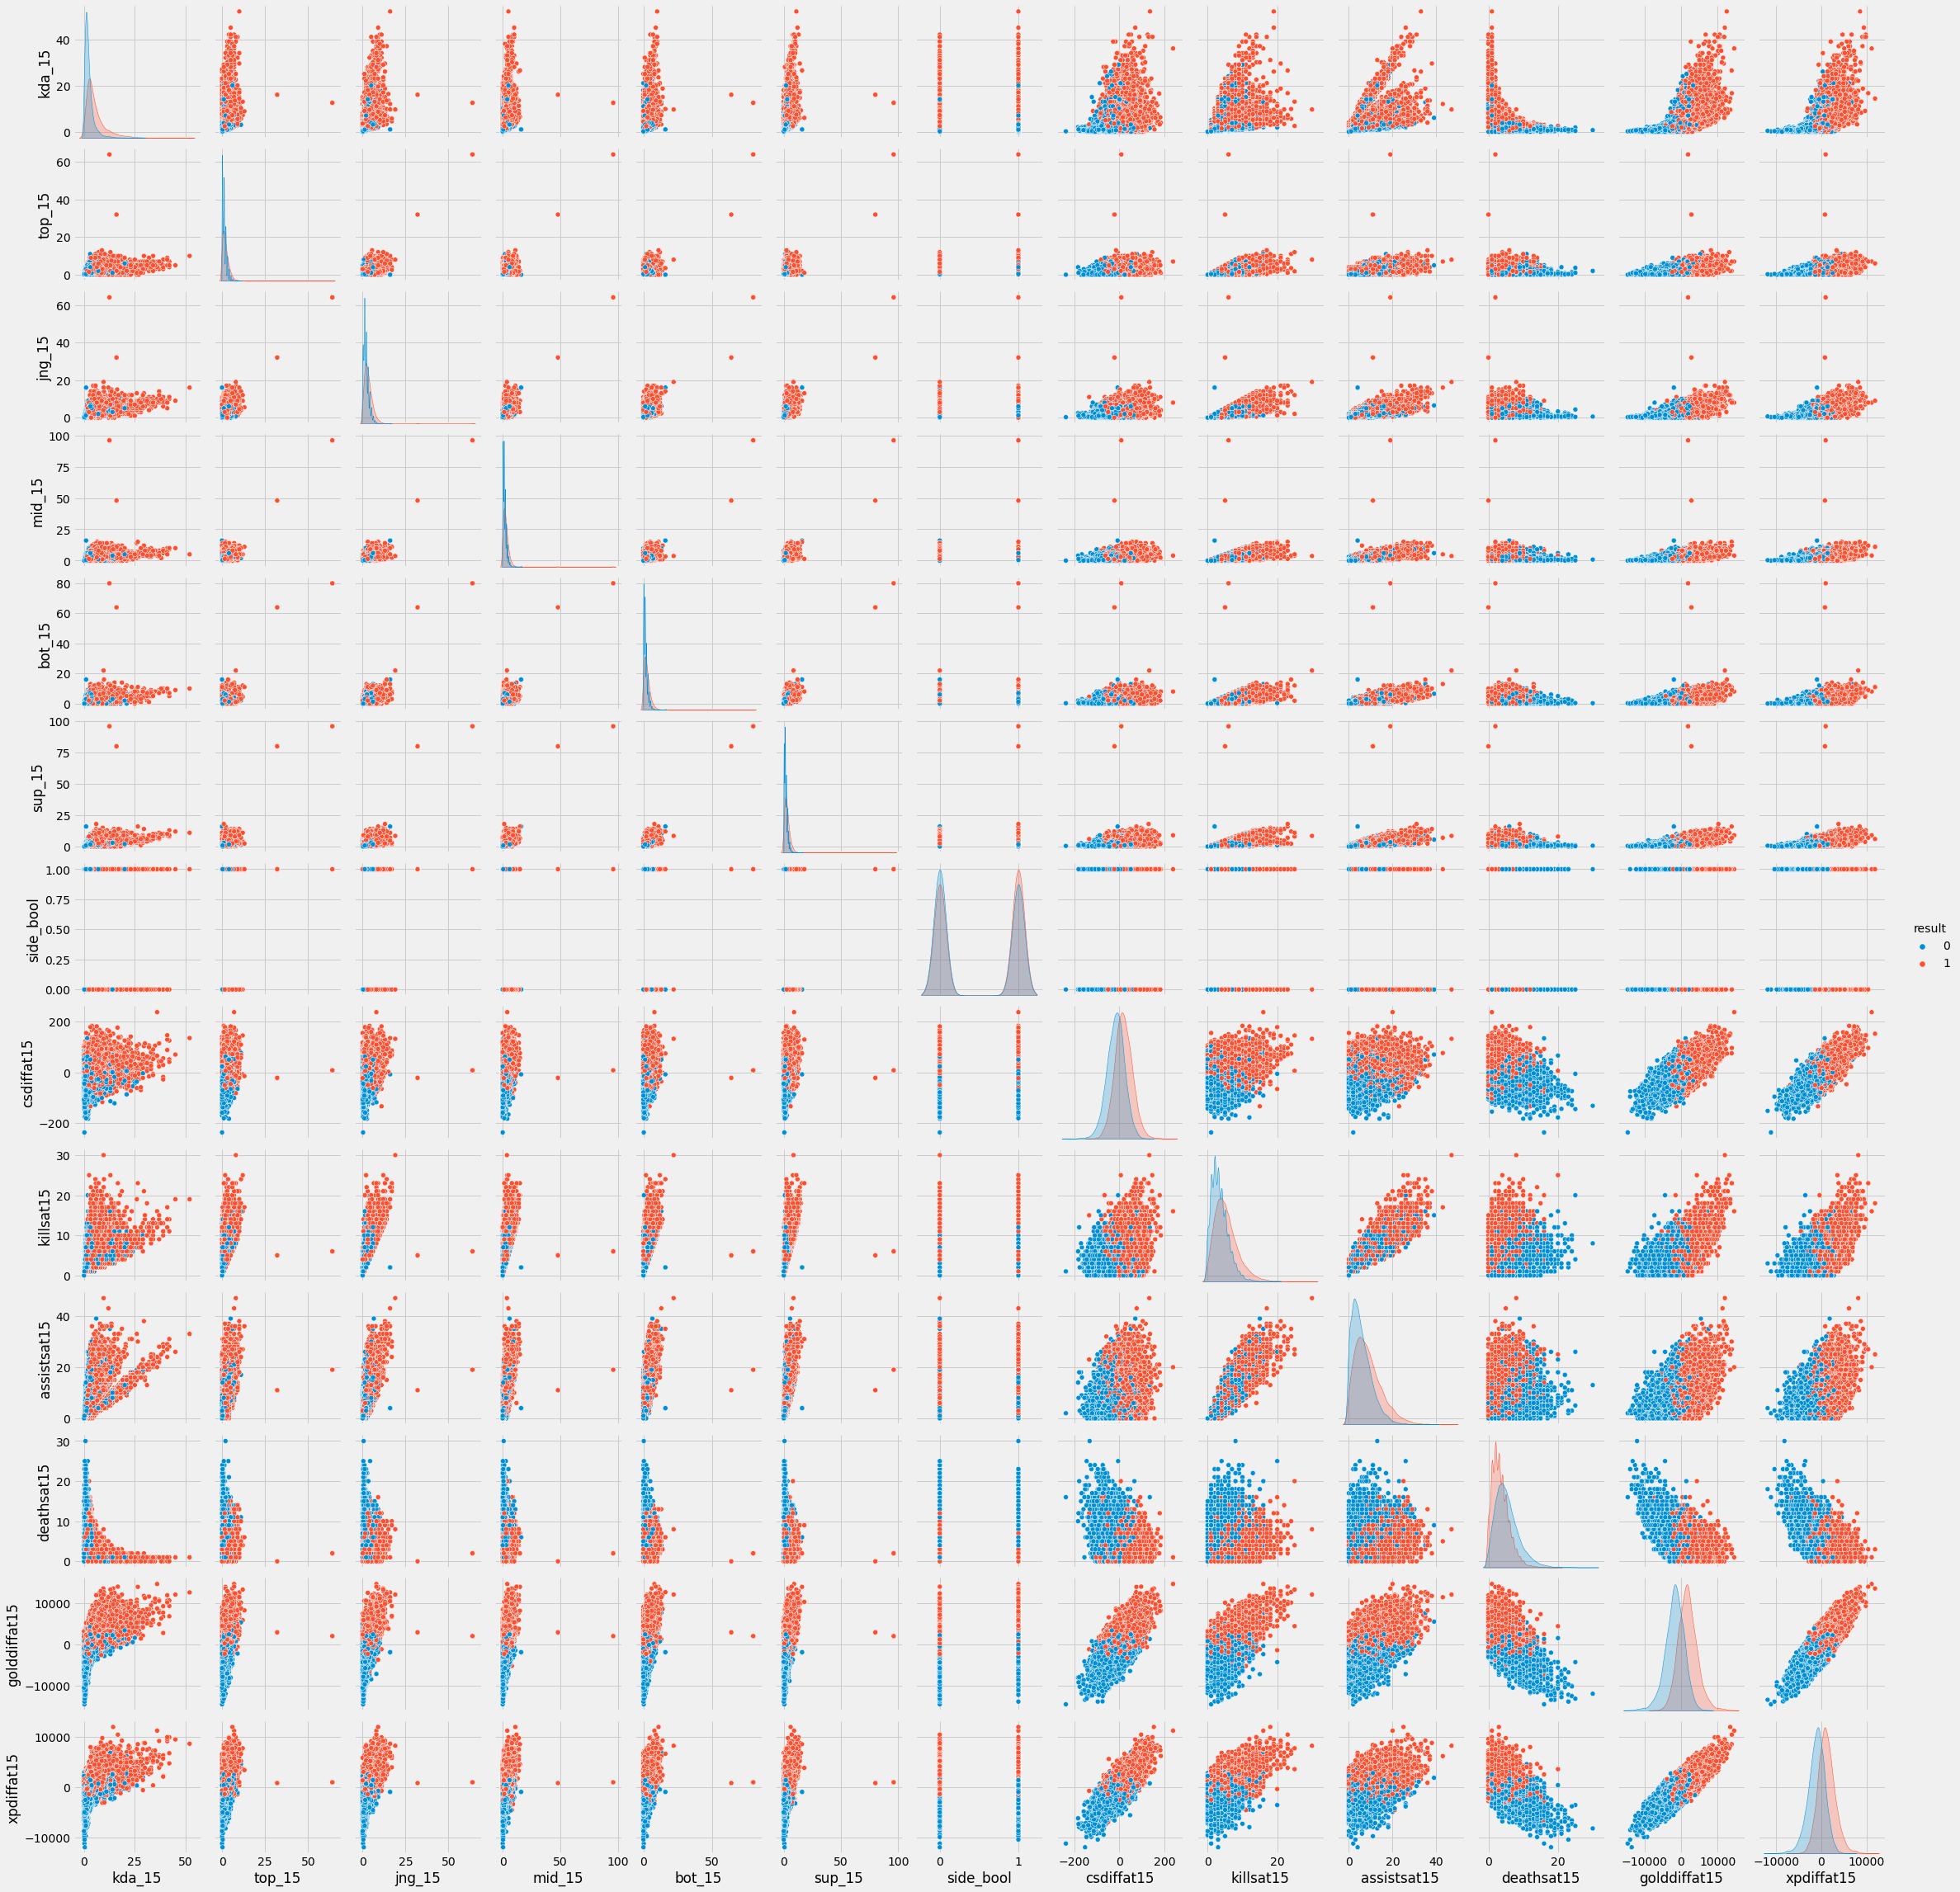

In [9]:
sns.pairplot(df_plot, hue = 'result')

# Modeling

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_plot.drop(columns = 'result'), df_plot['result'],
                                                    test_size = 0.2, random_state=42)

train_df = X_train.copy()
train_df['result'] = y_train

test_df = X_test.copy()
test_df['result'] = y_test

In [11]:
lr = LogisticRegression(max_iter = 500)

### Cross-validating to tune hyperparameters

In [12]:
c_range = list(range(1,50))
param_grid = dict(C = c_range)

In [13]:
grid = GridSearchCV(lr, param_grid, cv=10, scoring='f1')

In [14]:
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                               27, 28, 29, 30, ...]},
             scoring='f1')

In [15]:
print('Best params: ', grid.best_params_)
print('Best score:', grid.best_score_)

Best params:  {'C': 21}
Best score: 0.7585731231513281


## Using tuned parameters to finalize training/score model

In [23]:
lr = LogisticRegression(C = 21, max_iter = 500, multi_class = 'multinomial')
lr.fit(X_train,y_train)

LogisticRegression(C=21, max_iter=500, multi_class='multinomial')

In [24]:
y_pred = lr.predict(X_train)
f1_score(y_train, y_pred)

0.7583620997500298

[[6423 2026]
 [2037 6374]]


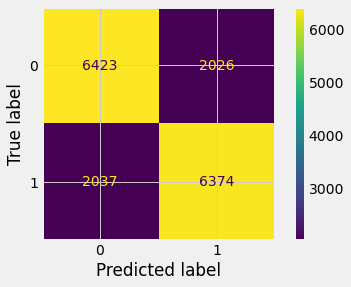

In [22]:
print(confusion_matrix(y_train,y_pred))
plot_confusion_matrix(lr, X_train, y_train)

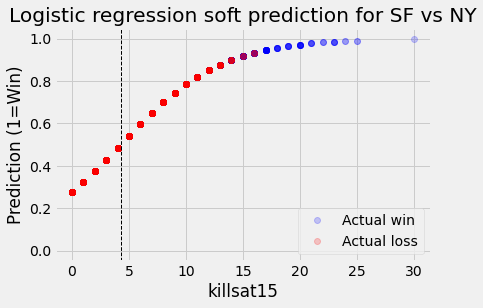

In [19]:
def viz_SF_LR(df, feat, model, hard_classification=True, decision_boundary=False):
    model.fit(df[[feat]], df['result'])
    
    # extract elevation feature and hard or soft predictions
    feature = df[[feat]].values
    if hard_classification:
        predictions = model.predict(feature)
    else:
        predictions = model.predict_proba(feature)[:, 1] 

    # color filter true class labels and plot predictions
    sf_mask = (df['result'] == 1).values
    plt.plot(feature[sf_mask], predictions[sf_mask], 'bo', label='Actual win', alpha=0.2)
    plt.plot(feature[~sf_mask], predictions[~sf_mask], 'ro', label='Actual loss', alpha=0.2)
    
    # optionally calculate and display decision boundary as dotted line
    if decision_boundary:
        b_0, b_1 = model.intercept_, model.coef_[0]
        plt.gca().axvline(-b_0/b_1,c='k',ls='--',lw=1)
    
    # plot formatting
    plt.ylim(-0.05, 1.05)
    plt.xlabel(feat)
    plt.ylabel('Prediction (1=Win)')
    type_str = 'hard' if hard_classification else 'soft'
    plt.title('Logistic regression ' + type_str + ' prediction for SF vs NY')
    plt.legend(loc='lower right')

lr1 = LogisticRegression()

viz_SF_LR(train_df, 'killsat15', lr1, hard_classification=False, decision_boundary = True)



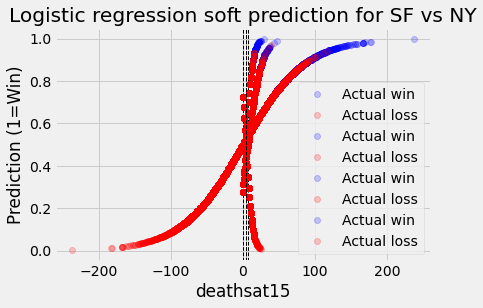

In [59]:
fift_lst = ['csdiffat15','assistsat15','killsat15','deathsat15']
for feat in fift_lst:
    viz_SF_LR(train_df, feat, lr1, hard_classification=False, decision_boundary = True)